# Выбор функций активации для многослойных нейронных сетей

#### 1. Логистическая функция (сигмоида)

<img src="pic/sigm.png" width="170"/>

In [1]:
import numpy as np

X = np.array([1, 1.4, 2.5])
w = np.array([0.4, 0.3, 0.5])


def net_input(X, w):
    return np.dot(X, w)


def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))


def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)


print('P(y=1|x) = ', logistic_activation(X, w))

P(y=1|x) =  0.8879529614430097


Если мы рассчитаем общий вход (z) и используем его для логистической
активации нейрона с указанными значениями признаков и весовыми коэффициентами, то получим значение 0.888, которое можно интерпретировать
как 88.8%-ную вероятность того, что конкретный образец x принадлежит положительному классу.

Однако, выходной слой, включающий множество элементов с логистической активацией, не выпускает содержательные и интерпретируемые значения вероятностей:

In [3]:
W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

A = np.array([1, 0.1, 0.4, 0.6])

Z = np.dot(W, A)
y_proba = logistic(Z)
print('общий вход: ', Z)
print('Выходные элементы: ', y_proba)

общий вход:  [1.78 0.76 1.65]
Выходные элементы:  [0.85569687 0.68135373 0.83889105]


В выводе видно, что результирующие значения не могут интерпретироваться как вероятности для задачи с тремя классами (значения в сумме не дают 1).
Один из способов прогнозирования метки класса на основе полученных ранее выходных эл-ов предусматривает применение значения максимума:

In [4]:
print('спрогнозированная метка: ', np.argmax(y_proba))

спрогнозированная метка:  0


#### 2. Многопеременная логистическая функция (softmax)

<img src="pic/softmax.png" width="170"/>

Функция softmax является мягкой формой
функции argmax; вместо предоставления одиночного индекса класса она
выдает вероятность каждого класса. Следовательно, она позволяет вычислять содержательные вероятности в многоклассовых окружениях (полиномиальная логистическая регрессия). 


In [5]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))


y_proba = softmax(Z)
print('Вероятности: ', y_proba)

Вероятности:  [0.44668973 0.16107406 0.39223621]


In [6]:
np.sum(y_proba)

1.0

In [7]:
import tensorflow as tf

Z_tensor = tf.expand_dims(Z, axis=0)
tf.keras.activations.softmax(Z_tensor)

<tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[0.44668973, 0.16107406, 0.39223621]])>

#### 3. Расширение выходного спектра с использованием гиперболическоrо тангенса

<img src="pic/tanh.png" width="290"/>

Гиперболический тангенс - масштабированная версия логистической функции.
Его приемущество в том, что он имеет более широкий выходной спектр и диапазоны в открытом интервале (-1, 1), которые могут улучшить сходимость алгоритма обратного распространения.

Логистическая функция возвращает выходной сигнал находящийся в открытом интервале (0, 1).

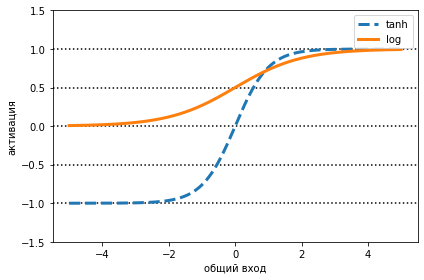

In [14]:
import matplotlib.pyplot as plt


def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)


z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel('общий вход')
plt.ylabel('активация')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')

plt.plot(z, tanh_act,
         linewidth='3', linestyle='--',
         label='tanh')
plt.plot(z, log_act,
         linewidth='3',
         label='log')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Формы двух сигмоидальных кривых выглядят очень похожими, но выходное пространство у функции tanh в два раза больше, чем у функции logistic.

In [15]:
np.tanh(z)

array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])

In [16]:
tf.keras.activations.tanh(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=
array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])>

In [17]:
# логистическая функция в scipy
from scipy.special import expit
expit(z)

array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])

In [18]:
tf.keras.activations.sigmoid(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=
array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])>

#### 4. Активация на основе выпрямленного линейного элемента (ReLU)

<img src="pic/relu.png" width="200"/>

Выпрямленный линейный элемент - еще
одна функция активации, которая часто применяется в глубоких нейронных
сетях. Прежде чем погружаться в детали ReLU, мы должны сделать шаг назад и понять проблему исчезновения градиентов, присущую активациям на
основе гиперболического тангенса и логистической функции. 


Пусть у нас первоначально имеется общий вход z1 = 20, который изменяется на z2 = 25. Вычислив активацию в форме гиперболического тангенса,
мы получаем ф(z) = 1.0 и ф(z) = 1.0, что указывает на отсутствие изменений в выходе (из-за асимптотического поведения функции гиперболического
тангенса и численных ошибок). 


Это означает, что производная активаций относительно общего входа
уменьшается, когда z становится большим. В результате выяснение весов на
стадии обучения крайне замедляется, т.к. члены градиента могут быть очень -
близкими к нулю. Активация ReLU решает такую проблему.

Кроме того, ReLU - нелинейная функция, которая хорошо подходит для
изучения сложных функций с нейронными сетями. Более того, производная ReLU относительно входа всегда равна 1 для положительных входных
значений. По этой причине она решает проблему исчезновения градиентов,
что делает ее подходящей для глубоких нейронных сетей.

In [19]:
tf.keras.activations.relu(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=array([0.   , 0.   , 0.   , ..., 4.985, 4.99 , 4.995])>

<img src="pic/activations.png"/>

In [ ]:
553